In [55]:
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras

In [56]:

data_dir = "Data/"

#Nadefinované labels dle dokumentace na Kagglu
disease_label = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Demented",
}

In [57]:
df_train = pd.read_parquet(f"{data_dir}train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow") #loadujeme parquet dataset
df_test  = pd.read_parquet(f"{data_dir}test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
df_test.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [58]:
#df_test/df_train jsou ve formátu slovníku obsahující jednotlivé bytes kvůli .parquet file type
def dict_to_image(image_dict): #přijímá argument slovníku -> df_test nebo df_train
    if isinstance(image_dict, dict) and 'bytes' in image_dict: #pokud je image_dict slovník a obsahuje binar. data z .parquet file
        byte_string = image_dict['bytes'] #binar data uložím
        nparr = np.frombuffer(byte_string, np.uint8) #převede binar data na array čísel (8 bit čísla)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE) #cv dekdoduje array, nahodí grayscale a vracíme img
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")
    
df_train['img_arr'] = df_train['image'].apply(dict_to_image) #vytvoříme new sloupec
df_train.drop("image", axis=1, inplace=True)

df_test['img_arr'] = df_test['image'].apply(dict_to_image)
df_test.drop("image", axis=1, inplace=True)
df_train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [59]:
df_test.shape

(1280, 2)

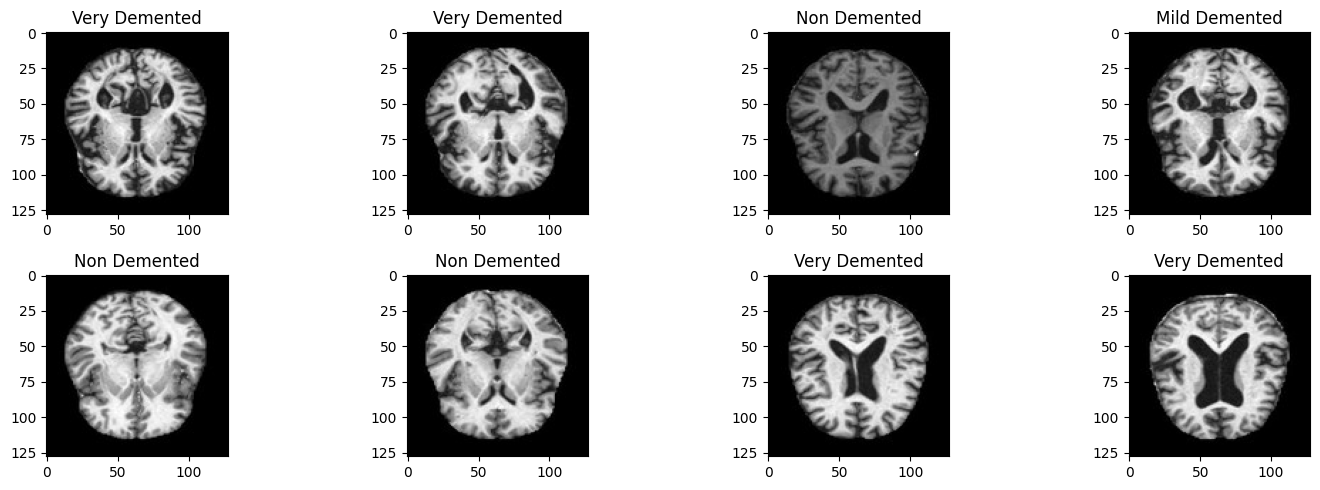

In [60]:
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df_test))
    axes.imshow(df_train.iloc[rand]['img_arr'], cmap="gray")
    axes.set_title(disease_label[df_train.iloc[rand]['label']])
plt.tight_layout()
plt.show()

In [61]:
N_CLASSES = df_train['label'].nunique()

print(f"Original Labels: {df_train['label'].unique()}")
N_CLASSES = df_train['label'].nunique()
print(f"Original N_CLASSES: {N_CLASSES}")
# Ensure labels are in range [0, N_CLASSES-1]
label_mapping = {label: idx for idx, label in enumerate(sorted(df_train['label'].unique()))}
print(f"Label Mapping: {label_mapping}")
df_train['label'] = df_train['label'].map(label_mapping)
print(f"Updated Labels: {df_train['label'].unique()}")

class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["img_arr"] # Get the label from the df
        label = self.dataframe.iloc[idx]["label"] # Get the img numpy array from the df
        # The CNN requires we add a channel dimension i.e. (128, 128) -> (1, 128, 128)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)
        return image, label
    
class BaselineCNN_WeightedRandomSample(nn.Module):
    def __init__(self, n_classes):
        super(BaselineCNN_WeightedRandomSample, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.out = nn.Linear(128, N_CLASSES)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

class BaselineCNN_HEM(nn.Module):
    def __init__(self, n_classes):
        super(BaselineCNN_HEM, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.out = nn.Linear(128, N_CLASSES)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x
    
class BaselineCNN(nn.Module):
    def __init__(self, n_classes):
        super(BaselineCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.out = nn.Linear(128, N_CLASSES)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

##CROSS_EVAL##

# Define the CNN model with dropout
class BaselineCNN_CE(nn.Module):
    def __init__(self, n_classes):
        super(BaselineCNN_CE, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout after the first conv block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(num_features=64)
        self.dropout2 = nn.Dropout(p=0.4)  # Dropout after the second conv block
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.dropout3 = nn.Dropout(p=0.5)  # Dropout before the output layer
        self.out = nn.Linear(128, n_classes)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.out(x)
        return x

#Third attempt: removed some dropout layers and the result was a bit more accurate, still not better than the original
# Define the CNN model with dropout
class BaselineCNN_CE_Dropped(nn.Module):
    def __init__(self, n_classes):
        super(BaselineCNN_CE_Dropped, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        # Removed dropout here to retain feature learning capacity
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(num_features=64)
        self.dropout2 = nn.Dropout(p=0.2)  # Reduced dropout in convolutional blocks
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.dropout3 = nn.Dropout(p=0.3)  # Moderate dropout for dense layers
        self.out = nn.Linear(128, n_classes)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.out(x)
        return x

#Fourth attempt: reduced the dropout probabilities to very low values (p=0.1)
class BaselineCNN_CE_Drop01(nn.Module):
    def __init__(self, n_classes):
        super(BaselineCNN_CE_Drop01, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(num_features=64)
        # Remove dropout in convolutional layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.dropout3 = nn.Dropout(p=0.1)  # Very low dropout for dense layer
        self.out = nn.Linear(128, n_classes)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.batchnorm2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.out(x)
        return x
    
#Fifth attempt: added another convolutional layer, kept one low dropout for dense layer → accuracy a bit better than with the original model
class BaselineCNN_CE_ConvAdd(nn.Module):
    def __init__(self, n_classes):
        super(BaselineCNN_CE_ConvAdd, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(num_features=64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Additional layer
        self.pool3 = nn.MaxPool2d(2, 2)
        self.batchnorm3 = nn.BatchNorm2d(num_features=128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.dropout3 = nn.Dropout(p=0.1)  # Low dropout for dense layer
        self.out = nn.Linear(128, n_classes)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.batchnorm2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.out(x)
        return x

#Sixth attempt: added convolutional layers, removed dropout, the best result, therefore overfitting is not a significant issue here
class BaselineCNN_CE_ConvAdded_DropMinus(nn.Module):
    def __init__(self, n_classes):
        super(BaselineCNN_CE_ConvAdded_DropMinus, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(num_features=64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Additional layer
        self.pool3 = nn.MaxPool2d(2, 2)
        self.batchnorm3 = nn.BatchNorm2d(num_features=128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.out = nn.Linear(128, n_classes)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.batchnorm2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

class DifferentOdBaseline(nn.Module):
    def __init__(self, n_classes):
        super(DifferentOdBaseline, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 32, 64)
        self.out = nn.Linear(64, n_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x
    
# --
# StudyModel_1
# --

class StudyModel_1(nn.Module):
    def __init__(self, n_classes):
        super(StudyModel_1, self).__init__()
        
        # První blok
        self.block1_conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.block1_conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.block1_pool = nn.MaxPool2d(2, 2)
        self.block1_conv3 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.block1_conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.block1_pool2 = nn.MaxPool2d(2, 2)
        self.block1_conv5 = nn.Conv2d(64, 256, kernel_size=3, padding=1)
        self.block1_pool3 = nn.MaxPool2d(2, 2)
        self.block1_bn = nn.BatchNorm2d(256)
        self.block1_dropout = nn.Dropout(0.2)
        self.block1_flatten = nn.Flatten()
        self.block1_fc = nn.Linear(256 * 16 * 16, 128)  # Přizpůsobení velikosti
        
        # Druhý blok
        self.block2_conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.block2_conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.block2_pool = nn.MaxPool2d(2, 2)
        self.block2_conv3 = nn.Conv2d(32, 128, kernel_size=5, padding=2)
        self.block2_conv4 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.block2_pool2 = nn.MaxPool2d(2, 2)
        self.block2_conv5 = nn.Conv2d(128, 512, kernel_size=5, padding=2)
        self.block2_pool3 = nn.MaxPool2d(2, 2)
        self.block2_bn = nn.BatchNorm2d(512)
        self.block2_dropout = nn.Dropout(0.2)
        self.block2_flatten = nn.Flatten()
        self.block2_fc = nn.Linear(512 * 16 * 16, 128)  # Přizpůsobení velikosti
        
        # Spojení a výstup
        self.concat_fc = nn.Linear(128 + 128, 128)
        self.out = nn.Linear(128, n_classes)
        
    def forward(self, x):
        # První blok
        x1 = F.relu(self.block1_conv1(x))
        x1 = F.relu(self.block1_conv2(x1))
        x1 = self.block1_pool(x1)
        x1 = F.relu(self.block1_conv3(x1))
        x1 = F.relu(self.block1_conv4(x1))
        x1 = self.block1_pool2(x1)
        x1 = F.relu(self.block1_conv5(x1))
        x1 = self.block1_pool3(x1)
        x1 = self.block1_bn(x1)
        x1 = self.block1_dropout(x1)
        x1 = self.block1_flatten(x1)
        x1 = F.relu(self.block1_fc(x1))
        
        # Druhý blok
        x2 = F.relu(self.block2_conv1(x))
        x2 = F.relu(self.block2_conv2(x2))
        x2 = self.block2_pool(x2)
        x2 = F.relu(self.block2_conv3(x2))
        x2 = F.relu(self.block2_conv4(x2))
        x2 = self.block2_pool2(x2)
        x2 = F.relu(self.block2_conv5(x2))
        x2 = self.block2_pool3(x2)
        x2 = self.block2_bn(x2)
        x2 = self.block2_dropout(x2)
        x2 = self.block2_flatten(x2)
        x2 = F.relu(self.block2_fc(x2))
        
        # Spojení a výstup
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.concat_fc(x))
        x = self.out(x)
        return x
#--    
# KreasLikeModel - předělaný z kaggle
#--

class KerasLikeModel(nn.Module):
    def __init__(self, n_classes):
        super(KerasLikeModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.05)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(p=0.2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(512 * 4 * 4, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64)
        self.dropout_fc2 = nn.Dropout(p=0.2)

        self.out = nn.Linear(64, n_classes)

    def forward(self, x):
        # Blok 1
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Blok 2
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)

        # Blok 3
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout2(x)

        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool4(x)

        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = self.pool5(x)
        x = self.dropout3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.bn_fc1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)

        x = self.out(x)
        return x
    
# --
# O něco lepší než Baseline generovaný od GPT
# --

import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelOdGPT(nn.Module):
    def __init__(self, n_classes):
        super(ModelOdGPT, self).__init__()
        

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16,
                               kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm2d(num_features=16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(p=0.1)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,
                               kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm2d(num_features=32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(p=0.1)
        

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=5, padding=2)
        self.bn3   = nn.BatchNorm2d(num_features=64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 64)
        self.out = nn.Linear(64, n_classes)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.drop3(x)

        x = torch.flatten(x, start_dim=1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        
        return x

##
# Ivča - ResNet, Evaluace samostatně
##
import torch
import torch.nn as nn
import torchvision.models as models

class AdvancedCNN(nn.Module):
    def __init__(self, n_classes):
        super(AdvancedCNN, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        
        # 1) Vytáhneme původní váhy první konvoluce (shape [64, 3, 7, 7])
        old_weights = self.base_model.conv1.weight.data

        # 2) Vytvoříme novou první konvoluční vrstvu s 1 kanálem
        new_conv = nn.Conv2d(
            in_channels=1,    # <- nově 1 kanál pro grayscale
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        
        # 3) Převezmeme „průměrové“ váhy z původní konvoluce, aby se zachoval co nejvíce
        #    charakter předtrénovaných vah. Průměrujeme přes dim=1 (kanály).
        with torch.no_grad():
            # [64, 1, 7, 7] = průměr [64, 3, 7, 7] přes kanálovou dimenzi
            new_conv.weight = nn.Parameter(old_weights.mean(dim=1, keepdim=True))
        
        # 4) Přiřadíme novou vrstvu zpět do ResNetu
        self.base_model.conv1 = new_conv

        # 5) Zmrazíme parametry – tak jako v původním kódu
        for param in self.base_model.parameters():
            param.requires_grad = False
        for param in self.base_model.layer4.parameters():
            param.requires_grad = True

        # 6) Upravíme výstupní vrstvu (FC) pro požadovaný počet tříd
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, n_classes)
        )

    def forward(self, x):
        return self.base_model(x)


# Hyperparameters
learning_rate = 0.0001
NEPOCHS = 20
batch_size = 32

train_dataset = ImageDataset(df_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def train_model_with_hem(model, loader, optimizer, num_epochs=NEPOCHS):
    criterion = nn.CrossEntropyLoss(reduction='none')  # Calculate loss per sample
    train_losses = []
    
    for epoch in tqdm.tqdm(range(num_epochs), total=num_epochs):
        running_loss = 0.0
        hard_examples = []

        for i, data in enumerate(loader, 0):
            inputs, labels = data[0], data[1]
            optimizer.zero_grad()

            outputs = model(inputs)
            losses = criterion(outputs, labels)  # Per-sample loss

            # Hard Example Mining: select top-k hardest samples
            k = int(0.2 * len(losses))  # Use top 20% hardest examples
            hard_indices = torch.topk(losses, k=k).indices
            hard_inputs = inputs[hard_indices]
            hard_labels = labels[hard_indices]

            # Compute loss for hard examples only
            hard_outputs = model(hard_inputs)
            hard_loss = criterion(hard_outputs, hard_labels).mean()

            hard_loss.backward()
            optimizer.step()

            running_loss += hard_loss.item()

        epoch_loss = running_loss / len(loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    print('Finished Training')
    return model, train_losses

#model = BaselineCNN()
#optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
#model, train_losses = train_model_with_hem(model, train_loader, optimizer)


Original Labels: [2 0 3 1]
Original N_CLASSES: 4
Label Mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3}
Updated Labels: [2 0 3 1]


In [62]:

#folder_path = r"C:\Users\Tomas\Desktop\MRI-GradCAM\Models"
#file_name   = "BaselineCNN_HEM_20epochs_32atch_lrate.pth"
#save_path   = os.path.join(folder_path, file_name)

#torch.save(model.state_dict(), save_path)
#print(f"Model saved to: {save_path}")

In [63]:
#Train
train_dataset = ImageDataset(df_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#Test
test_dataset = ImageDataset(df_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [64]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Sem doplňte Váš dataset pro test - například:
# test_dataset = ImageDataset(df_test)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

ARCHITECTURES_MAP = {
    "BaselineCNN": BaselineCNN,   # předpoklad, že BaselineCNN je definována
    "BaselineCNN_HEM_15epochs": BaselineCNN_HEM,     # a AnotherCNN také
    "BaselineCNN_HEM_20epochs": BaselineCNN_HEM,
    "BaselineCNN_HEM_20epochs_16batch": BaselineCNN_HEM,
    "BaselineCNN_HEM_20epochs_32batch_lrate": BaselineCNN_HEM,
    "BaselineCNN_HEM_20epochs_64batch_lrate": BaselineCNN_HEM,
    "BaselineCNN_WeightedRandomSampler": BaselineCNN_WeightedRandomSample,
    "BaselineCNN_CrossEntropyLoss": BaselineCNN_CE,
    "BaselineCNN_CrossEntropyLoss_50epochs": BaselineCNN_CE,
    "BaselineCNN_CrossEntropyLoss_AddedConv": BaselineCNN_CE_ConvAdd,
    "BaselineCNN_CrossEntropyLoss_AddedConvMinusDropout": BaselineCNN_CE_ConvAdded_DropMinus,
    "BaselineCNN_CrossEntropyLoss_Dropout_10": BaselineCNN_CE_Drop01,
    "BaselineCNN_CrossEntropyLoss_Reduced_Drop": BaselineCNN_CE_Dropped,
    "ModelByGPT": ModelOdGPT,
    "KerasModel": KerasLikeModel,
    "StudyModel_Halved": StudyModel_1
   # "AdvancedCNN_ResNet": AdvancedCNN_ResNet
    # ... a tak dále
}

# Funkce na vyhodnocení (výpočet accuracy) modelu na test datech
def evaluate_model(model, data_loader):
    """Funkce na výpočet accuracy (0.0–1.0) na testovacím datasetu."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total if total > 0 else 0.0

# Adresář s modely
models_folder = r"C:\Users\Tomas\Desktop\MRI-GradCAM\Models"
model_files = [f for f in os.listdir(models_folder) if f.endswith(".pth")]

model_accuracies = {}

for model_file in model_files:
    # Odstraníme koncovku ".pth" → získáme klíč do ARCHITECTURES_MAP
    base_name = model_file[:-4]  # 'BaselineCNN_CrossEntropyLoss_50epochs' apod.

    if base_name in ARCHITECTURES_MAP:
        # Získáme třídu dané architektury
        model_class = ARCHITECTURES_MAP[base_name]

        # Vytvoříme instanci, nahrajeme váhy
        temp_model = model_class(n_classes=N_CLASSES)
        model_path = os.path.join(models_folder, model_file)
        temp_model.load_state_dict(torch.load(model_path))

        # Vyhodnotíme na testovacích datech
        acc = evaluate_model(temp_model, test_loader)  # test_loader musí existovat
        model_accuracies[base_name] = acc
    else:
        print(f"Soubor {model_file} nemá odpovídající klíč v ARCHITECTURES_MAP, přeskočeno.")

# Seřadíme výsledky podle accuracy (od nejlepšího po nejhorší)
sorted_accuracies = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)

print("=== Výsledky (setříděné) ===")
for rank, (name, acc) in enumerate(sorted_accuracies, start=1):
    print(f"{rank}. {name}: {acc*100:.2f}%")

c:\Users\Tomas\anaconda3\envs\MRI-scan\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tomas\anaconda3\envs\MRI-scan\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Tomas\AppData\Local\Temp\ipykernel_12716\567910814.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyto

RuntimeError: Error(s) in loading state_dict for AdvancedCNN:
	size mismatch for base_model.conv1.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7, 7]).

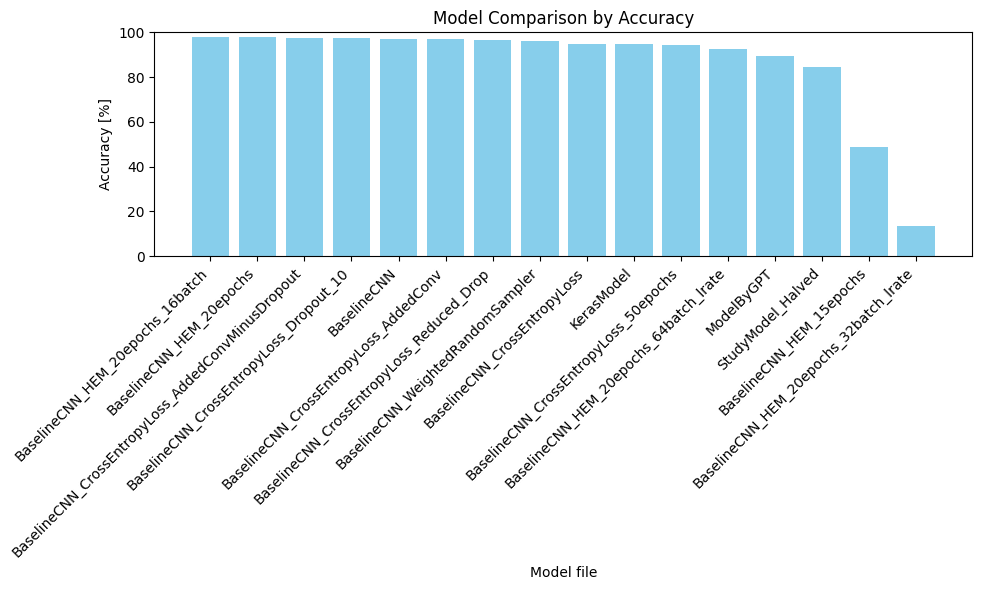

In [ ]:
import matplotlib.pyplot as plt

model_names = [x[0] for x in sorted_accuracies]
accuracies = [x[1]*100 for x in sorted_accuracies]

plt.figure(figsize=(10,6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy [%]")
plt.xlabel("Model file")
plt.title("Model Comparison by Accuracy")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [12]:
"""def predict(m, dl, device):
    m.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in dl:
            images = images
            outputs = m(images)
            _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

def result_summary(predictions, true_labels):
    # Accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    print('Confusion Matrix:')
    print(conf_matrix)
    
predictions, true_labels = predict(model, train_loader, device)
result_summary(predictions, true_labels)"""

"def predict(m, dl, device):\n    m.eval()  # Set model to evaluation mode\n    predictions = []\n    true_labels = []\n    \n    with torch.no_grad():  # Disable gradient computation for inference\n        for images, labels in dl:\n            images = images\n            outputs = m(images)\n            _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability\n            predictions.extend(preds.cpu().numpy())\n            true_labels.extend(labels.cpu().numpy())\n    \n    return predictions, true_labels\n\ndef result_summary(predictions, true_labels):\n    # Accuracy\n    accuracy = accuracy_score(true_labels, predictions)\n    print(f'Accuracy: {accuracy:.4f}')\n\n    # Confusion Matrix\n    conf_matrix = confusion_matrix(true_labels, predictions)\n    print('Confusion Matrix:')\n    print(conf_matrix)\n    \npredictions, true_labels = predict(model, train_loader, device)\nresult_summary(predictions, true_labels)"

In [13]:
"""test_dataset = ImageDataset(df_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
predictions_test, test_labels = predict(model, test_loader, device)

result_summary(predictions_test, test_labels)"""

'test_dataset = ImageDataset(df_test)\ntest_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)\npredictions_test, test_labels = predict(model, test_loader, device)\n\nresult_summary(predictions_test, test_labels)'

In [14]:
"""
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        target = output[:, target_class]

        self.model.zero_grad()
        target.backward(retain_graph=True)

        weights = torch.mean(self.gradients, dim=(2, 3))  #global průměr
        cam = torch.zeros(self.activations.shape[2:], dtype=torch.float32)
        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i]

        cam = F.relu(cam)
        cam = cam / torch.max(cam)  #normalizace
        return cam.detach().cpu().numpy()

#zvýraznění tříd
class_weighting = {
    'Very Demented': 1.5,
    'Mild Demented': 1.3,
    'Moderate Demented': 1.2,
    'Non Demented': 1.0
}

def adjust_cam(cam, label):
    weight = class_weighting.get(label, 1.0)
    cam = cam ** weight  #zvýraznění dle váhy
    return cam / np.max(cam)  

#inicializace
model = model.to(device)
grad_cam = GradCAM(model, model.conv2)

#testování na random brázku
input_image, label = test_dataset[0]
input_tensor = input_image.unsqueeze(0).to(device)  
#real class
true_class = label.item()
true_label = disease_label[true_class]

#tvorba GradCAM pro realnou classu
cam_map = grad_cam.generate_cam(input_tensor, true_class)
cam_map = adjust_cam(cam_map, true_label)

#resize protože byl problem s fitem, ale tohle to nějak řeší
cam_map_resized = F.interpolate(torch.tensor(cam_map).unsqueeze(0).unsqueeze(0), size=input_image.shape[1:], mode='bilinear', align_corners=False).squeeze(0).squeeze(0).numpy()


plt.figure(figsize=(10, 5))

# Originální obrázek
plt.subplot(1, 2, 1)
plt.imshow(input_image.squeeze(0).cpu(), cmap='gray')
plt.title(f'Original Image (Class: {true_label})')
plt.axis('off')

# Grad-CAM překryv
plt.subplot(1, 2, 2)
plt.imshow(input_image.squeeze(0).cpu(), cmap='gray')
plt.imshow(cam_map_resized, cmap='jet', alpha=0.5)
plt.title('Grad-CAM Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 4, figsize=(15, 8))
axs = ax.flatten()
for i, axes in enumerate(axs):
    idx = np.random.randint(0, len(test_dataset))
    input_image, label = test_dataset[idx]
    input_tensor = input_image.unsqueeze(0).to(device)
    cam_map = grad_cam.generate_cam(input_tensor, label.item())

    # Zvýraznění CAM dle třídy
    label_name = disease_label[label.item()]
    cam_map = adjust_cam(cam_map, label_name)
    cam_map_resized = F.interpolate(torch.tensor(cam_map).unsqueeze(0).unsqueeze(0), size=input_image.shape[1:], mode='bilinear', align_corners=False).squeeze(0).squeeze(0).numpy()

    axes.imshow(input_image.squeeze(0).cpu(), cmap='gray')
    axes.imshow(cam_map_resized, cmap='jet', alpha=0.5)
    axes.set_title(f'Class: {label_name}')
    axes.axis('off')

plt.tight_layout()
plt.show()
"""

"\nimport torch\nimport torch.nn.functional as F\nimport matplotlib.pyplot as plt\nimport numpy as np\n\nclass GradCAM:\n    def __init__(self, model, target_layer):\n        self.model = model\n        self.target_layer = target_layer\n        self.gradients = None\n        self.activations = None\n        self.hook_layers()\n\n    def hook_layers(self):\n        def forward_hook(module, input, output):\n            self.activations = output\n\n        def backward_hook(module, grad_in, grad_out):\n            self.gradients = grad_out[0]\n\n        self.target_layer.register_forward_hook(forward_hook)\n        self.target_layer.register_backward_hook(backward_hook)\n\n    def generate_cam(self, input_tensor, target_class):\n        self.model.eval()\n        output = self.model(input_tensor)\n        target = output[:, target_class]\n\n        self.model.zero_grad()\n        target.backward(retain_graph=True)\n\n        weights = torch.mean(self.gradients, dim=(2, 3))  #global průměr